In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math 
import sklearn.preprocessing 
import random
import yaml
import h5py
import logging
import datetime
import os
import time

import pprint
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler
import torch.nn.functional as F


from load_matlab_timedata import get_data_from
from src.TSGenerator import f_Y, f_X, get_func_timeseries
from src.DataLoader import TimeSeriesDataset
from src.model_utils import init_logger, plot_shared_scale, plot_multiscale
from src.Model import LSTM
from src.Losses import myLoss, aux_loss_jordan, prognose_dy

from torch.optim.lr_scheduler import ReduceLROnPlateau  


In [2]:
import copy

## Loading config files, setup execution parameters, init objects

In [3]:
plt.rcParams['figure.figsize'] = 20, 7.
CONFIG_FILENAME = "model_params_jordan.yaml"
# ! ls DC_motor_simulation
with open(CONFIG_FILENAME, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
   
pprint.pprint(config)


p_net = config['network_params']

p_train = config['train_params']

p_gen = config['generator_params']

p_data = config['data_params']
need_normalize = p_data['need_normalize']

{'data_params': {'best_discrete_k': 3,
                 'integration_step': 0.01,
                 'leave_nth': 13,
                 'mat_file': 'DC_motor_simulation/train_3_parameters.mat',
                 'need_normalize': True,
                 'specific_data_source': 'DC_motor_simulation/test_3_parameters_d_001_2.mat',
                 'specific_data_sources': {'dur': 'DC_motor_simulation/test_3_parameters_d_001_2.mat',
                                           'noice': 'DC_motor_simulation/test_3_parameters_5_15_1_20_additive_noise.mat',
                                           'range': 'DC_motor_simulation/test_3_parameters_v_0_33.mat',
                                           'sin': 'DC_motor_simulation/test_3_parameters_5_15_1_20_additive_sin.mat'},
                 'test_size': 0.3,
                 'tested_models': ['jordan_indep_estimate_1l 2h '
                                   '1b_18_May_11_42PM.pt',
                                   'jordan_full_blind_lower_cp_002

In [4]:
# load models for compare

In [5]:

evaluated_model_names = config['data_params']['tested_models']
config['data_params']['specific_data_source'] = config['data_params']['specific_data_sources']['dur']
evaluated_models = [ (torch.load(name), name ) for name in evaluated_model_names]
for model, model_name in evaluated_models:
    model.eval()
    print(model_name)
    for name, parameter in model.named_parameters():
        print(name, '\t\t', parameter.shape)
        print()

jordan_indep_estimate_1l 2h 1b_18_May_11_42PM.pt
jordan 		 torch.Size([1, 3])

lstm.weight_ih_l0 		 torch.Size([8, 4])

lstm.weight_hh_l0 		 torch.Size([8, 2])

lstm.bias_ih_l0 		 torch.Size([8])

lstm.bias_hh_l0 		 torch.Size([8])

linear.weight 		 torch.Size([1, 2])

linear.bias 		 torch.Size([1])

jordan_full_blind_lower_cp_002_1l 2h 1b_18_May_11_42PM.pt
jordan 		 torch.Size([1, 3])

lstm.weight_ih_l0 		 torch.Size([8, 4])

lstm.weight_hh_l0 		 torch.Size([8, 2])

lstm.bias_ih_l0 		 torch.Size([8])

lstm.bias_hh_l0 		 torch.Size([8])

linear.weight 		 torch.Size([1, 2])

linear.bias 		 torch.Size([1])

jordan_vanilla_3_1l_2n_1b_18_May_11_42PM.pt
jordan 		 torch.Size([1, 3])

lstm.weight_ih_l0 		 torch.Size([8, 4])

lstm.weight_hh_l0 		 torch.Size([8, 2])

lstm.bias_ih_l0 		 torch.Size([8])

lstm.bias_hh_l0 		 torch.Size([8])

linear.weight 		 torch.Size([1, 2])

linear.bias 		 torch.Size([1])

jordan_full_blind_par_004_param_1l 2h 1b_19_May_12_20AM.pt
jordan 		 torch.Size([1, 3])

l

# Set parameters

In [6]:
init_logger(config)

logging.info("Experiment started with params")
logging.info(f"data_par: {p_data}")
logging.info(f"net_par: {p_net}")
logging.info(f"train_par: {p_train}") 

logger inited to file [only_batcheslogs/exp_2019-05-19_02:40:57.log]


## Init data loader and get appropriate part of data

## Creating objects from imported files

In [7]:
# from src.Model import LSTM, LSTM_jordan
from src.Losses import myLoss, prognose_dy, myLoss_jordan  # imports here for faster rerun and debug procedure

loss_fn = myLoss_jordan


using 1.0 of data
loading from [DC_motor_simulation/test_3_parameters_d_001_2.mat]
X normalized, norms: [14.99794219]
x shape (76924, 1)
x_normalized shape (76924, 1)


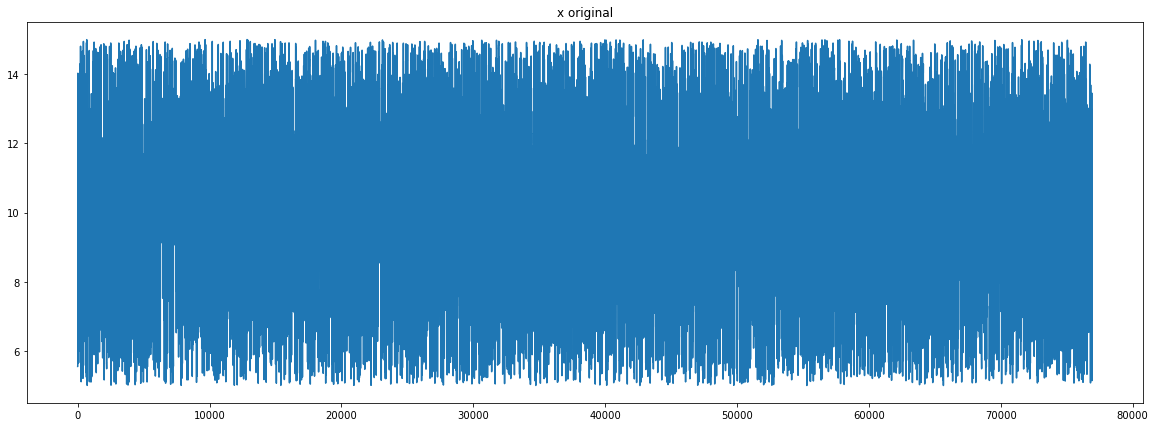

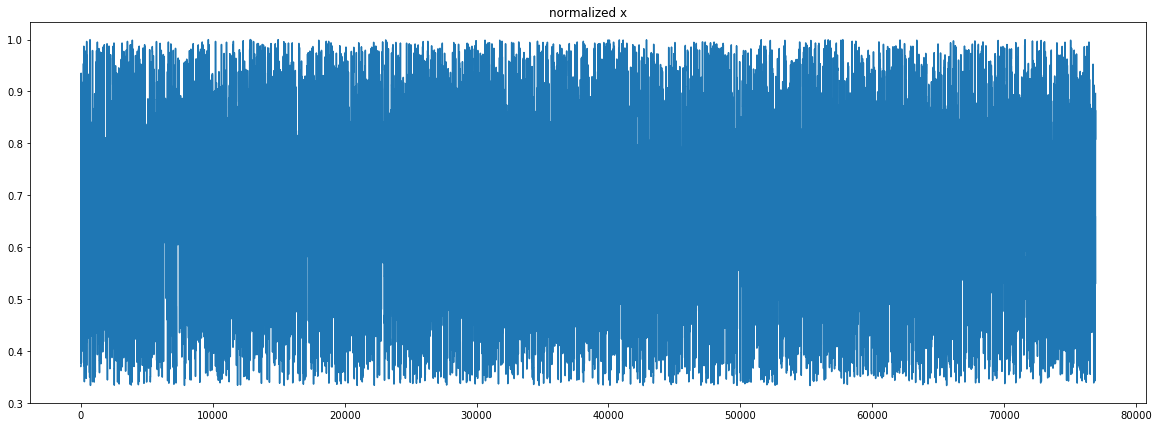

Y normalized, norms: [0.01323596]
input shape (76924, 1)
input partition shape (76924, 1)
output partition shape (76924, 1)
stacked Y shape  (76860, 1)
Y_tensor torch.Size([76860, 1])
X_tensor torch.Size([64, 76859, 1])
test set: [76860] batches
data_loading time 22.79695963859558 secs


In [8]:
# todo add time tracking for this cell
use_part = p_data['use_part_of_data']
print(f"using {use_part} of data")

t_tick = time.time()

test_ts_ds = TimeSeriesDataset(config=config,
                               partition=(0, 1),                        
                               logging=logging
                              ,specific_data_source='specific_data_source')



# print(f"train set: [{len(train_ts_ds)}] batches")
print(f"test set: [{len(test_ts_ds)}] batches")

if need_normalize:
    config['x_norm'] = test_ts_ds.x_norms[0]
    config['y_norm'] = test_ts_ds.y_norms[0]
    config['x_norm']
else:
    config['x_norm'] = 1
    config['y_norm'] = 1
    config['x_norm']

test_dl = DataLoader(dataset = test_ts_ds,
                      batch_sampler = BatchSampler(
                          sampler = SequentialSampler(test_ts_ds), 
                          batch_size = p_train['batch_size'],
                          drop_last = True)
                     )
train_dl = []
    
t_tock = time.time()
dataload_time = t_tock - t_tick
print(f"data_loading time {dataload_time} secs")

## Inspecting data we have, get several batches and look inside on pretty large scale to see individual iterations:

x [batch_size, retrospective_steps, channels] :torch.Size([1024, 64, 1])
y [batch_size, channels]: torch.Size([1024, 1])
y_last [slice_size]: (150,)


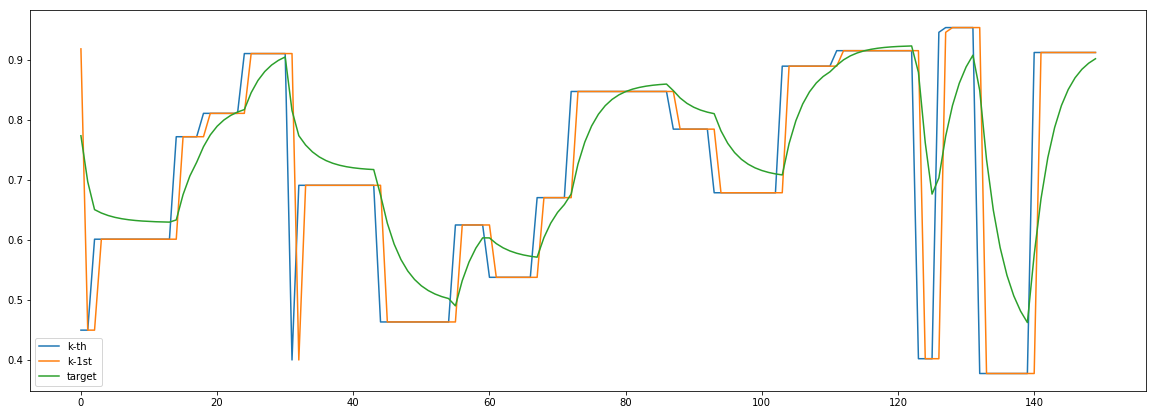

x [batch_size, retrospective_steps, channels] :torch.Size([1024, 64, 1])
y [batch_size, channels]: torch.Size([1024, 1])
y_last [slice_size]: (150,)


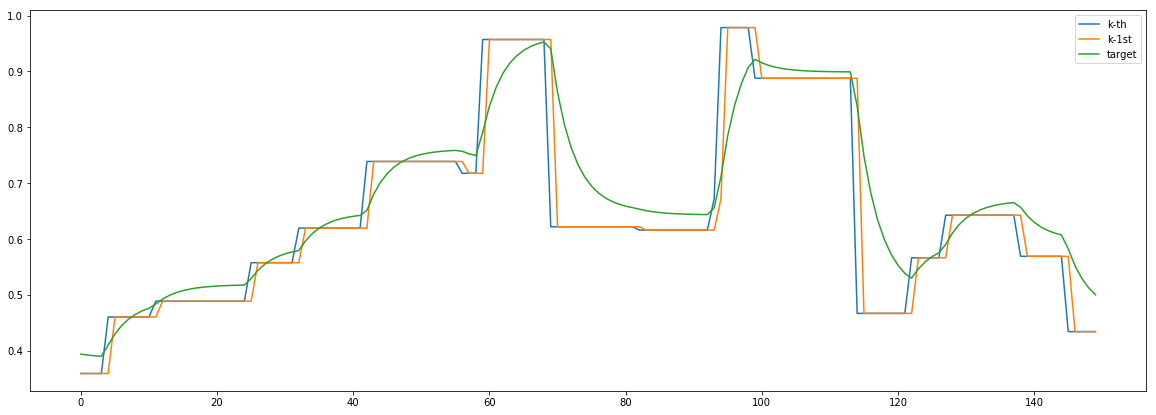

In [9]:
f, t = 0, 150
for i, batch in enumerate(test_dl):
    x, y, ind = batch
    print(f"x [batch_size, retrospective_steps, channels] :{x.shape}")
    print(f"y [batch_size, channels]: {y.shape}")
    y_kth = y.detach().numpy()[f:t, 0]
    print(f"y_last [slice_size]: {y_kth.shape}")
    x = x.transpose(0,1)
    plt.plot(x.detach().numpy()[-1][f:t], label='k-th')
    plt.plot(x.detach().numpy()[-2][f:t], label='k-1st')
    plt.plot(y_kth, label='target')
    plt.legend()
    plt.show()
    if i == 1:
        break

In [10]:
logging.info("History INITIALIZED")
num_epochs=1
hist = {
    
    "train":{
        "batches":{
            "main":np.zeros(len(train_dl)),
            "aux":np.zeros(len(train_dl)),
            "jordan":np.zeros(len(train_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "jordan":np.zeros(num_epochs)
        }
    },
    
    "eval_train":{
        "batches":{
            "main":np.zeros(len(train_dl)),
            "aux":np.zeros(len(train_dl)),
            "jordan":np.zeros(len(train_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "jordan":np.zeros(num_epochs)
        }
    },
    
    "eval_test":{
        "batches":{
            "main":np.zeros(len(test_dl)),
            "aux":np.zeros(len(test_dl)),
            "jordan":np.zeros(len(test_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "jordan":np.zeros(num_epochs)
        }
    },
    
    'mean_params_sample':
    {
        '1':np.zeros(num_epochs),
        '2':np.zeros(num_epochs),            
    },
    'lr': np.zeros(num_epochs),
    'loss_rate': np.zeros(num_epochs),
    'weights_sum': np.zeros(num_epochs), 
    'weights_var': np.zeros(num_epochs),
    
    'grads':{
        'batches':{name: np.zeros(len(train_dl)) for name, parameter in model.named_parameters()},
        'epochs':{name: np.zeros(num_epochs) for name, parameter in model.named_parameters()}
    },
    'weights':{
        'batches':{name: np.zeros(len(train_dl)) for name, parameter in model.named_parameters()},
        'epochs':{name: np.zeros(num_epochs) for name, parameter in model.named_parameters()}
    },
    'vars':{
        'batches':{name: np.zeros(len(train_dl)) for name, parameter in model.named_parameters()},
        'epochs':{name: np.zeros(num_epochs) for name, parameter in model.named_parameters()}
    },
    'param_grads':{
        'batches':{"p1":np.zeros(len(train_dl)), "p2":np.zeros(len(train_dl))},
        'epochs':{"p1":np.zeros(num_epochs), "p2":np.zeros(num_epochs)}
    },
    'aux_global':[],
    'grad_global':{'p1':[], 'p2':[], 'lstm':[], 'linear':[]}
}

In [11]:
def batch_iteration(iter_index, model, optimizer, batch_data, backprop, hist_part):
    
    x_batch, y_batch, indexes = batch_data
    x_batch.transpose_(0, 1) # todo get rid of it
#     print(x_batch.shape)
    model.hidden = model.init_hidden()

    y_pred, jordan = model(x_batch)
    losses = loss_fn(y_pred, jordan.t(), y_batch, x_batch, config)
    main_loss, aux_loss, aux_residuals, jordan_loss = losses
    
#     aux_loss *= 10**p_train['aux_loss']['scaling_order']
    
#     jordan_loss *= 10**p_train['aux_loss']['scaling_order'] # TODO change to special
    
    main_loss *= 10**p_train['core_loss']['scaling_order']
    losses = [main_loss]    
    
    
    if backprop:
            
        combined_loss = sum(losses)

        optimizer.zero_grad()

        combined_loss.backward()
    # TODO or manually add weight decay here when grad is ready
    #         print(f"losses after scaling: m[{main_loss.item()}] a[{aux_loss.item()}] c[{const_loss.item()}]")
        for name, parameter in model.named_parameters():
            hist['grads']['batches'][name][iter_index] = parameter.grad.sum().item()
            hist['weights']['batches'][name][iter_index] = parameter.sum().item()
            hist['vars']['batches'][name][iter_index] = parameter.var().item()
        hist['param_grads']['batches']['p1'][iter_index] = model.jordan.grad[0][0].item()
        hist['param_grads']['batches']['p2'][iter_index] = model.jordan.grad[0][1].item()
        
        hist['grad_global']['p1'].append(model.jordan.grad[0][0].item())
        hist['grad_global']['p2'].append(model.jordan.grad[0][1].item())
        
        hist['grad_global']['lstm'].append(sum([p.grad.abs().sum() for p in model.lstm.parameters()]).item())
        hist['grad_global']['linear'].append(sum([p.grad.abs().sum() for p in model.linear.parameters()]).item())
        hist['aux_global'].append(aux_loss.item())
        
        optimizer.step()
    
    hist_part["main"][iter_index] = main_loss.item()
    hist_part["aux"][iter_index] = aux_loss.item()
    hist_part["jordan"][iter_index] = jordan_loss.item()
    
    return y_pred, jordan

In [12]:
def update_long_term_hist(batches_hist, long_term_hist):
    mean_main = np.average(batches_hist["main"])
    mean_aux = np.average(batches_hist["aux"])
    mean_jord = np.average(batches_hist["jordan"])
    long_term_hist["main"][t] = mean_main
    long_term_hist["aux"][t] = 0
    long_term_hist["jordan"][t] = 0
    return mean_main, mean_aux, mean_jord

In [13]:
def slice_loss_sum(losses_dict, index):
    return sum([val[index] for val in losses_dict.values()])

## Evaluate model

In [14]:
logging.info("Training process STARTED")


def eval_model(model, hist):
    
    model.hidden = model.init_hidden()
    # EVAL
    t=0
    with torch.no_grad():

          model = model.eval()

          for i, data in enumerate(tqdm(test_dl)):
              batch_local_hist = hist['eval_test']['batches']
              long_term_hist=hist["eval_test"]["epochs"]

              y_pred_test, jordan = batch_iteration(
                iter_index=i,
                model=model,
                optimizer=None,
                batch_data=data,
                backprop=False,
                hist_part=batch_local_hist
              )

#           update_long_term_hist(batches_hist=batch_local_hist,
#                                 long_term_hist=long_term_hist)

    # /EVAL

    # VISUALISE ITERATION PRED
    x_batch_test, y_batch_test, indexes = data
    print(jordan)

    sample_y_pred_test = y_pred_test[:, 0].detach().numpy().copy()
    sample_y_pred_test -= np.min(sample_y_pred_test)
    sample_y_pred_test /= (np.max(sample_y_pred_test) - np.min(sample_y_pred_test))
    normed_data = y_batch_test[:, 0].detach().numpy().copy()
    normed_data -= np.min(normed_data)
    normed_data /= (np.max(normed_data) - np.min(normed_data))
    plot_shared_scale([
            (y_pred_test[:, 0].detach().numpy(), "Preds"),
            (sample_y_pred_test,"Normed_preds" ),
             (y_batch_test[:, 0].detach().numpy(), "Data"),
             (normed_data, "Normed_data"),
             (x_batch_test[-1].detach().numpy(), "Input")
    ],
        title = 'TEST PRED'
    )

    plot_shared_scale([
            (y_pred_test[:, 0].detach().numpy(), "Preds"),
    #         (sample_y_pred_test,"Normed_preds" ),
             (y_batch_test[:, 0].detach().numpy(), "Data"),
    #          (normed_data, "Normed_data"),
             (x_batch_test[-1].detach().numpy(), "Input")
    ],
        title = 'TEST PRED'
    )

   

    visualise_resid = True
    if visualise_resid:
        residuals = y_batch_test[:, 0] - y_pred_test[:, 0]
        plot_multiscale(
                [
                 (residuals.detach().numpy(), "Red"), 
                 (y_batch_test[:, 0].detach().numpy(),"Green")
                ],
            title = 'TEST RESID'
        )

    # UPDATE LR
    val_loss = slice_loss_sum(hist['eval_test']['epochs'], t)
    # scheduler.step(val_loss)
    hist['weights_sum'][t] = torch.as_tensor([p.sum() for p in model.parameters(recurse=True)]).sum().item()
    hist['weights_var'][t] = torch.as_tensor([p.var() for p in model.parameters(recurse=True)]).sum().item()

    # todo fixit. Turned off because case with bias turned off parameter is absent in dict and causes error
#     for name, parameter in model.named_parameters():
#           hist['weights']['epochs'][name][t] = np.mean(hist['weights']['batches'][name])
#           hist['vars']['epochs'][name][t] = np.mean(hist['vars']['batches'][name])
    


    # FINAL PROGRESS LOGGING
    msg = "Epoch [{t}] \n \
    train_loss[{train_loss}] \n \
    eval_train[{eval_train}] \n \
    eval_test[{eval_test}]".format(t=t,
                                train_loss=sum([val[t] for val in hist['train']['epochs'].values()]), 
                                eval_train=sum([val[t] for val in hist['eval_train']['epochs'].values()]),
                                eval_test=sum([val[t] for val in hist['eval_test']['epochs'].values()])
                               )
    print(msg)
    logging.info(msg)
    
    return hist
    # /FINAL PROGRESS LOGGING

In [15]:
model.jordan[:, 1]

tensor([0.9994], grad_fn=<SelectBackward>)

# Summary:

In [16]:
# TODO  From file |  Normalizing value |  EVAL ERROR

In [17]:
evaluated_models

[(LSTM_jordan(
    (lstm): LSTM(4, 2)
    (linear): Linear(in_features=2, out_features=1, bias=True)
  ), 'jordan_indep_estimate_1l 2h 1b_18_May_11_42PM.pt'), (LSTM_jordan(
    (lstm): LSTM(4, 2)
    (linear): Linear(in_features=2, out_features=1, bias=True)
  ),
  'jordan_full_blind_lower_cp_002_1l 2h 1b_18_May_11_42PM.pt'), (LSTM_jordan(
    (lstm): LSTM(4, 2)
    (linear): Linear(in_features=2, out_features=1, bias=True)
  ), 'jordan_vanilla_3_1l_2n_1b_18_May_11_42PM.pt'), (LSTM_jordan(
    (lstm): LSTM(4, 2)
    (linear): Linear(in_features=2, out_features=1, bias=True)
  ),
  'jordan_full_blind_par_004_param_1l 2h 1b_19_May_12_20AM.pt'), (LSTM_jordan(
    (lstm): LSTM(4, 2)
    (linear): Linear(in_features=2, out_features=1, bias=True)
  ), 'jordan_full_blind_par_007_1l 2h 1b_19_May_12_20AM.pt'), (LSTM_jordan(
    (lstm): LSTM(4, 2)
    (linear): Linear(in_features=2, out_features=1, bias=True)
  ),
  'jordan_full_blind_par_004_output_weights_1l 2h 1b_19_May_01_29AM.pt'), (LSTM_jo

In [18]:
hists =  []
for model, model_name in evaluated_models:
    print(model_name)
    hists.append((model_name, eval_model(model, copy.deepcopy(hist))))


jordan_indep_estimate_1l 2h 1b_18_May_11_42PM.pt


TypeError: new() received an invalid combination of arguments - got (Tensor, requires_grad=bool), but expected one of:
 * (torch.device device)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, torch.device device)
      didn't match because some of the keywords were incorrect: requires_grad
 * (object data, torch.device device)
      didn't match because some of the keywords were incorrect: requires_grad


In [ ]:
vals = [sum(model_hist['eval_test']['batches']['main'])/config['train_params']['batch_size'] for model_name, model_hist in hists]

In [ ]:
baseline_val = min(vals)

In [ ]:
models_dict = {name: model for model, name in evaluated_models}

In [ ]:
evaluated_models[0][0].get_num_params()

In [ ]:
model_lstm = [
    child_model for child_name, child_model in models_dict[model_name].named_children() if child_name == 'lstm'
][0]

In [ ]:

for model_name, model_hist in hists:
    print(model_name)
    print(sum(model_hist['eval_test']['batches']['main'])/config['train_params']['batch_size']/baseline_val)
    model_lstm = [child_model for child_name, child_model in models_dict[model_name].named_children() if child_name == 'lstm'][0]
    lstm_n_params = np.sum([np.prod(p.shape) for p in model_lstm.parameters()])
    print(f"model params total:[{int(models_dict[model_name].get_num_params())}] \t lstm:[{lstm_n_params}]")
    print()

In [ ]:
plot_shared_scale([
    (model_hist['eval_test']['batches']['main'], model_name)
    for model_name, model_hist in hists

]
)